# Text Classfication using TinyBert
* Dataset: <https://www.kaggle.com/columbine/imdb-dataset-sentiment-analysis-in-csv-format>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os 

import torch
import torch.nn as nn

import transformers
import torchflare.callbacks as cbs
import torchflare.metrics as metrics
import torchflare.criterion as crit
from torchflare.experiments import Experiment
from torchflare.datasets import TextDataloader


In [2]:
df = pd.read_csv("Train.csv")

In [3]:
train_df , valid_df =train_test_split(df , stratify = df.label,  test_size = 0.1, random_state = 42)

In [4]:
tokenizer = transformers.AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

train_dl = TextDataloader.from_df(
                        df = train_df,
                        input_col = 'text',
                        label_cols = 'label',
                        tokenizer = tokenizer,
                        max_len = 128).get_loader(batch_size = 16 , shuffle = True)

valid_dl = TextDataloader.from_df(
                        df = valid_df,
                        input_col = 'text',
                        label_cols = 'label',
                        tokenizer = tokenizer,
                        max_len = 128).get_loader(batch_size = 16)

In [5]:
class Model(torch.nn.Module):

    def __init__(self):

        super(Model , self).__init__()
        self.bert = transformers.BertModel.from_pretrained(
            "prajjwal1/bert-tiny", return_dict=False
        )
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(128, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _ , o_2 = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        b_o = self.bert_drop(o_2)
        output = self.out(b_o)
        return output

model = Model()

In [6]:
metric_list = [metrics.Accuracy(num_classes=2, multilabel=False)]

callbacks = [
    cbs.EarlyStopping(monitor="accuracy", patience=2, mode = "max"),
    cbs.ModelCheckpoint(monitor="accuracy" , mode = "max"),
    cbs.ReduceLROnPlateau(mode = "max" , patience = 2),
    cbs.NeptuneLogger(project_dir = "notsogenius/dl-experiments",
                     api_token = os.environ.get("NEPTUNE_API_TOKEN"),
                     experiment_name = "IMDB_CLASSIFICATION",
                     tags = ["tiny-bert" , "text_classification"])
]

# I want to define some custom weight decay to model paramters.
# We will use model_params as an argument in optimizer_params to tell torchflare that, hey we are using custom optimizer params for model.
# If model_params arguments is not used, torchflare by default will use model.parameters() as default params to optimizer.
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias"]
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]


In [9]:
exp = Experiment(
    num_epochs=5,
    fp16=True,
    device="cuda",
    seed=42,
)

# Compiling the experiment
exp.compile_experiment(
    model=model,
    optimizer="AdamW",
    optimizer_params=dict(model_params = optimizer_parameters, lr=3e-5), # used model_params argument for custom optimizer params.
    callbacks=callbacks,
    criterion= crit.BCEWithLogitsFlat, # Using BCEWithLogitsFlat since I dont want to handle shapes my outputs and targets.
    metrics=metric_list,
    main_metric="accuracy",
)

# Training the models.
exp.fit_loader(train_dl = train_dl , valid_dl = valid_dl)

https://app.neptune.ai/notsogenius/dl-experiments/e/DLEX-3

Epoch: 1/5
Train: 2250/2250 [=========================]- 99s 44ms/step - train_loss: 0.5049 - train_accuracy: 0.7446
Valid: 250/250 [=========================]- 7s 28ms/step - val_loss: 0.4080 - val_accuracy: 0.7523

Epoch: 2/5
Train: 2250/2250 [=========================]- 132s 59ms/step - train_loss: 0.3889 - train_accuracy: 0.7866
Valid: 250/250 [=========================]- 10s 39ms/step - val_loss: 0.3849 - val_accuracy: 0.7887

Epoch: 3/5
Train: 2250/2250 [=========================]- 145s 64ms/step - train_loss: 0.3410 - train_accuracy: 0.8081
Valid: 250/250 [=========================]- 11s 45ms/step - val_loss: 0.3605 - val_accuracy: 0.8092

Epoch: 4/5
Train: 2250/2250 [=========================]- 152s 68ms/step - train_loss: 0.2951 - train_accuracy: 0.8252
Valid: 250/250 [=========================]- 11s 45ms/step - val_loss: 0.3733 - val_accuracy: 0.8257

Epoch: 5/5
Train: 2250/2250 [=========================]- 153s 68ms

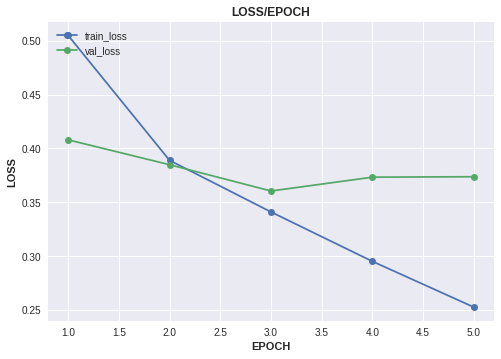

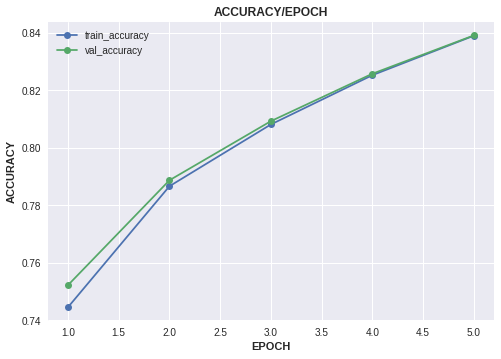

In [10]:
keys = ["loss" , "accuracy"]

exp.plot_history(keys = keys , save_fig = False , plot_fig = True)